
# 🌳 Homework: Programming Tree-Based Models

## 💡 Core Idea & Pipeline

This notebook provides a complete, hands-on pipeline for building, evaluating, and optimizing a decision tree classifier. The goal is to move beyond just calling `.fit()` and `.predict()` and to deeply understand the *process* of model tuning.

We will use the "Adult" (Census) dataset, a classic classification task to predict whether an individual's income is greater than $50K/year.

**Our pipeline will cover:**

1.  **Environment Setup:** Downloading the data and setting up reproducible hyperparameters.
2.  **Data Preprocessing:** This is a crucial and realistic step. We will load messy, real-world data and transform it into a clean, numerical format suitable for `scikit-learn`. This includes:
      * Handling missing values (marked as `?`).
      * Cleaning inconsistent data (the test set has artifacts).
      * Performing **One-Hot Encoding** for categorical features.
      * Splitting data into **three** distinct sets: **Train, Validation, and Test**.
3.  **Baseline Modeling:** We'll build a standard, unpruned decision tree to establish a "baseline" performance. We expect this model to be complex and to **overfit**.
4.  **Model Optimization (Pruning):** We'll use **Cost-Complexity Pruning (CCP)**, a robust method for finding a simpler, more generalizable tree. This is the core of the exercise:
      * We will use the **Training set** to *build* the trees.
      * We will use the **Validation set** to *select the best pruning hyperparameter (`ccp_alpha`)*.
      * We will (finally) use the **Test set** to *report the final, unbiased performance* of our chosen model.
5.  **Advanced Exploration:** We will investigate the `max_features` hyperparameter, which forms the basis of the **Random Forest** algorithm, to see how feature randomization affects model performance and structure.

---

## ✨**Your Tasks:**
You are required to complete **three coding problems** (each worth **5 or 10 points**) indicated by the marker:

```python
######################################
## WRITE YOUR CODE HERE (10 Points) ##
######################################
```


### Step1: Downloading the Training and Test Datasets

You can obtain the **Adult** dataset files — `adult.data` (training set) and `adult.test` (test set) — using one of the following methods:

1. **Direct download** from the URLs provided below.
2. **Download from Blackboard**, located in the directory for **HW2**.


In [1]:
import os
import urllib.request

# Data source URLs from the UCI Machine Learning Repository
urls = {
    "adult.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "adult.test": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
}

# Function to download the file if it doesn't exist
def download_if_missing(filename, url):
    """
    Checks for a local file and downloads it from a URL if missing.
    
    Args:
        filename (str): The local path to save the file.
        url (str): The remote URL to download from.
    """
    if not os.path.exists(filename):
        print(f"📥 Downloading: {filename} ...")
        # Use urllib to retrieve the file from the web
        urllib.request.urlretrieve(url, filename)
        print(f"✅ Saved: {filename}")
    else:
        print(f"✔ File already exists: {filename}")

# Run download for both files
for fname, link in urls.items():
    download_if_missing(fname, link)

✔ File already exists: adult.data
✔ File already exists: adult.test


### Step 2:Imports & Experiment Configuration

**Motivation:** This cell acts as our central control panel. We import all necessary libraries (`pandas` for data manipulation, `sklearn` for modeling, `matplotlib` for plotting) and define global constants.

Setting constants like `RANDOM_SEED` is **essential for reproducibility**. It ensures that every time we run this script, the "random" operations (like sampling and model training) will produce the exact same results. `N_TRAIN_SAMPLES` is set to a small number to speed up our experiments.

In [4]:
## First, we need to install all the packages using tsinghua source
### we use uv to install the packages, as uv enables to speed up the installation of the packages
#--system is used to install the packages in the system environment
!pip install uv -i https://pypi.tuna.tsinghua.edu.cn/simple
!uv pip install --system pandas numpy scikit-learn matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Using Python 3.11.9 environment at: c:\Users\BruceXing\AppData\Local\Programs\Python\Python311
Audited 4 packages in 5ms
Using Python 3.11.9 environment at: c:\Users\BruceXing\AppData\Local\Programs\Python\Python311
Audited 4 packages in 5ms


In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# --- 1. Hyperparameters & Global Settings ---

# Subsample size for training and testing.
# The full dataset has >30,000 rows, which can be slow to process.
# We use a small, fixed subset for fast experimentation and reproducibility.
N_TRAIN_SAMPLES = 500
N_TEST_SAMPLES = 50

# A single random seed for all steps ensures reproducibility
RANDOM_SEED = 42

# Proportion of the training data to hold out for validation
VAL_SPLIT_SIZE = 0.25

# Column names for the Adult dataset (not provided in the .data file)
COLUMN_NAMES = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Local file paths
LOCAL_TRAIN_FILE = 'adult.data'
LOCAL_TEST_FILE = 'adult.test'


print(f"--- Experiment Settings ---")
print(f"Random Seed: {RANDOM_SEED}")
print(f"Training Samples (Subsampled): {N_TRAIN_SAMPLES}")
print(f"Test Samples (Subsampled): {N_TEST_SAMPLES}")
print("-" * 30 + "\n")

--- Experiment Settings ---
Random Seed: 42
Training Samples (Subsampled): 500
Test Samples (Subsampled): 50
------------------------------



### Step3: Data Loading & Preprocessing

**Motivation:** This is the data engineering phase. Real-world data is never clean. We must load the data and transform it into a numerical feature matrix `X` and a target vector `y`.

**Key Steps:**

1.  **Load:** Read the CSVs using `pandas`. We must specify `sep=', '`, `na_values=' ?'`, and `skiprows=1` (for the test file) to handle the dataset's quirks.
2.  **Sample:** Use `.sample()` to grab a small, random subset, using our `RANDOM_SEED`.
3.  **Combine:** We **temporarily combine** the train and test sets. This is a critical step to ensure that `pd.get_dummies` (One-Hot Encoding) sees all possible categories from *both* sets, preventing a "mismatched columns" error later.
4.  **Clean:**
      * `dropna()`: A simple strategy to handle missing values (marked as `?`).
      * `.str.replace('.', ...)`: The test set's target variable has an extra period (e.g., `<=50K.`). We must remove it.
      * `.map(...)`: Convert the string target (`<=50K`) into a binary integer (`0` or `1`).
5.  **Encode:** Use `pd.get_dummies` to convert categorical columns (like 'workclass', 'occupation') into many binary (0/1) columns. `drop_first=True` is used to prevent perfect multicollinearity.
6.  **Split:** We split the data back into `train` and `test`. Then, we split the `train` data *again* into `X_train` and `X_val`. This gives us our three distinct sets.

In [6]:
# --- 2. Data Loading & Preprocessing ---

print("--- Step 1: Data Loading & Preprocessing ---")

# --- 2.1 Check for local files ---
# (Ensuring Cell 1 was run)
if not os.path.exists(LOCAL_TRAIN_FILE):
    print(f"Local file {LOCAL_TRAIN_FILE} not found. Please re-run Cell 1 to download.")
    raise FileNotFoundError(f"Local file {LOCAL_TRAIN_FILE} not found.")
else:
    print(f"Found local file: {LOCAL_TRAIN_FILE}")

if not os.path.exists(LOCAL_TEST_FILE):
    print(f"Local file {LOCAL_TEST_FILE} not found. Please re-run Cell 1 to download.")
    raise FileNotFoundError(f"Local file {LOCAL_TEST_FILE} not found.")
else:
    print(f"Found local file: {LOCAL_TEST_FILE}")

# --- 2.2 Load from local files ---
print("\nLoading data from local files...")
# Note the specific parameters needed for this dataset
df_train_raw = pd.read_csv(
    LOCAL_TRAIN_FILE,  # <-- Read from the local file
    names=COLUMN_NAMES,
    sep=', ',          # The separator is a comma *followed by a space*
    na_values=' ?',     # Missing values are marked with ' ?'
    engine='python'    # 'python' engine handles the 'sep' correctly
)
df_test_raw = pd.read_csv(
    LOCAL_TEST_FILE,   # <-- Read from the local file
    names=COLUMN_NAMES,
    sep=', ',
    na_values=' ?',
    skiprows=1,        # The test file has an extra header row
    engine='python'
)

# Randomly sample the data as specified
df_train = df_train_raw.sample(n=N_TRAIN_SAMPLES, random_state=RANDOM_SEED)
df_test = df_test_raw.sample(n=N_TEST_SAMPLES, random_state=RANDOM_SEED)

# To ensure consistent One-Hot Encoding, we combine train and test
# We add a 'set' marker to split them back up later
df_train['set'] = 'train'
df_test['set'] = 'test'
df_combined = pd.concat([df_train, df_test])


## View the raw-ish data
example_train = df_train.head(5)
example_test = df_test.head(5)

print("Training data example:")
example_train

--- Step 1: Data Loading & Preprocessing ---
Found local file: adult.data
Found local file: adult.test

Loading data from local files...
Training data example:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,set
14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States,<=50K,train
27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train
28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States,>50K,train
5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K,train
7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States,<=50K,train


In [7]:
print("\nTest data example:")
example_test


Test data example:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,set
13633,29,Private,189346,HS-grad,9,Never-married,Transport-moving,Unmarried,White,Male,0,0,40,United-States,<=50K.,test
1921,31,Private,137076,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K.,test
12140,52,Federal-gov,35546,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K.,test
9933,54,Local-gov,116428,10th,6,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K.,test
7745,41,Private,177054,HS-grad,9,Divorced,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,<=50K.,test


In [8]:

# --- 2.3 Preprocessing Pipeline ---
# 1. Filter NA values (as requested)
df_processed = df_combined.dropna()

# 2. Clean the target variable 'income'
#    The test set has an extra '.' (e.g., ' <=50K.'), which we must remove
df_processed['income'] = df_processed['income'].str.replace('.', '', regex=False)
#    Map the 'income' string to a binary 0/1 integer
df_processed['income'] = df_processed['income'].map({'<=50K': 0, '>50K': 1})

# 3. Convert categorical features to numeric (One-Hot Encoding)
#    Separate X (features) and y (target)
y = df_processed['income']
set_marker = df_processed['set']
X = df_processed.drop(['income', 'set'], axis=1)

#    Use pd.get_dummies for One-Hot Encoding
#    drop_first=True helps avoid multicollinearity (dummy variable trap)
X_processed = pd.get_dummies(X, drop_first=True)

# 4. Re-split the data back into train, val, and test sets
X_processed['set'] = set_marker
X_processed['income'] = y

# Split back into processed train/test sets
df_train_val_processed = X_processed[X_processed['set'] == 'train']
df_test_processed = X_processed[X_processed['set'] == 'test']

# Prepare final X and y for modeling
X_test = df_test_processed.drop(['income', 'set'], axis=1)
y_test = df_test_processed['income']

X_train_val = df_train_val_processed.drop(['income', 'set'], axis=1)
y_train_val = df_train_val_processed['income']

# Split the processed training data into a (smaller) train set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SPLIT_SIZE,
    random_state=RANDOM_SEED
)

print(f"\nOriginal train data {len(df_train_raw)} -> Sampled {len(df_train)} -> Cleaned {len(df_train_val_processed)}")
print(f"Original test data {len(df_test_raw)} -> Sampled {len(df_test)} -> Cleaned {len(df_test_processed)}")
print(f"Final Training Set (X_train): {X_train.shape}")
print(f"Final Validation Set (X_val): {X_val.shape}")
print(f"Final Test Set (X_test): {X_test.shape}")
print("Preprocessing complete.\n")


Original train data 32561 -> Sampled 500 -> Cleaned 500
Original test data 16281 -> Sampled 50 -> Cleaned 50
Final Training Set (X_train): (375, 72)
Final Validation Set (X_val): (125, 72)
Final Test Set (X_test): (50, 72)
Preprocessing complete.



### Step4: Building the Baseline Classifier

**Motivation:**
In this step, we construct our initial model, referred to as the *baseline classifier*. This decision tree is trained to its maximum possible depth (`max_depth=None` by default). As a result, the model is expected to exhibit high complexity, achieving perfect or near-perfect performance on the training dataset. However, such behavior typically indicates **overfitting**, where the model memorizes noise and idiosyncrasies in the training data, leading to poor generalization on unseen test data. The resulting test accuracy of this baseline model will serve as a benchmark for subsequent model improvements.

**Note:**
For a detailed explanation of all available parameters and to explore different parameter combinations, please refer to the [DecisionTreeClassifier documentation in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [9]:
# --- 3. Step 2: Build Base Classifier ---

print("--- Step 2: Base Classifier (Unpruned) ---")


######################################
## WRITE YOUR CODE HERE (5 Points) ##
######################################
# 🎯 Task:
# Build and evaluate your **baseline Decision Tree classifier**.
#
# Steps to follow:
# 1️⃣ Initialize a DecisionTreeClassifier instance.
#     - Use `criterion='entropy'` (this tells the tree to use *Information Gain*).
#     - Set `random_state=RANDOM_SEED` to make your results reproducible.
clf_base = DecisionTreeClassifier(
    criterion='entropy',      # Use Information Gain (entropy-based splitting)
    random_state=RANDOM_SEED  # Ensure reproducibility
)
# 2️⃣ Train the model using the *training set*.
#     - Hint: look for the `.fit()` method in the sklearn documentation.
#
clf_base.fit(X_train, y_train)
# 3️⃣ Generate predictions on the *test set*.
#     - Hint: check out the `.predict()` method.
#
y_pred_base = clf_base.predict(X_test)
# 🧭 Reference:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#
# ✅ Expected output:
# After training and prediction, you should have:
#   - A trained model object (clf_base)
#   - A vector of predicted labels (y_pred_base)
#
# 💡 (Tip: You do NOT need to manually tune parameters yet—just use defaults!)



--- Step 2: Base Classifier (Unpruned) ---


In [10]:
print("Base Model (Unpruned) Performance on Test Set:")
print(classification_report(y_test, y_pred_base))
print(f"Base Model (Unpruned) Depth: {clf_base.get_depth()}")

Base Model (Unpruned) Performance on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        39
           1       0.58      0.64      0.61        11

    accuracy                           0.82        50
   macro avg       0.74      0.75      0.75        50
weighted avg       0.83      0.82      0.82        50

Base Model (Unpruned) Depth: 13


### Step5: Pruning with Cost-Complexity Pruning (CCP)

**Motivation:** Our baseline model maybe overfit. Pruning is a technique to simplify the tree by "cutting off" the weakest branches. This makes the model less complex and helps it generalize better.

**CCP Pipeline:**

1.  **Get Path:** We use `cost_complexity_pruning_path` to generate a list of all possible "pruning levels," defined by the hyperparameter `ccp_alpha`. A higher `alpha` results in more pruning (a smaller tree).
2.  **Validate Alphas:** We loop through each `alpha` value. For each one, we train a *new* pruned tree on the `X_train` data.
3.  **Score:** We score that pruned tree on the **validation set (`X_val`)**. This is the most important step\! We are using the validation set to see which `alpha` gives the best performance on data it *wasn't* trained on.
4.  **Find Best:** We use `np.argmax` to find the `alpha` that produced the highest validation score.
5.  **Retrain Final Model:** Now that we have our "winning" `alpha`, we train *one final model*. This time, we use the best `alpha` and train on the **entire `X_train_val` set**. This lets our final model learn from all available training and validation data before its final test.
6.  **Final Evaluation:** We evaluate this new, pruned, retrained model on the `X_test` set. We hope to see a simpler tree (lower depth) and a *higher* test accuracy.

In [11]:
# --- 4. Step 3: Pruning using Validation Set (Cost-Complexity Pruning) ---

print("--- Step 3: Cost-Complexity Pruning (CCP) ---")

# Get the list of effective alphas and impurities
# This path is generated using *only* the training data
path = clf_base.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# We remove the last alpha, which corresponds to a tree with only one node (the root)
ccp_alphas = ccp_alphas[:-1]

clfs = []         # To store pruned trees
val_scores = []   # To store scores on the validation set

print(f"Validating on {len(ccp_alphas)} different alpha values...")
for ccp_alpha in ccp_alphas:
    # Create a new tree instance with the specified ccp_alpha
    clf_pruned = DecisionTreeClassifier(
        criterion='entropy',
        random_state=RANDOM_SEED,
        ccp_alpha=ccp_alpha  # This is the pruning parameter
    )
    
    # Fit the pruned tree *only* on the training data
    clf_pruned.fit(X_train, y_train)
    
    # Score the tree on the *validation* data
    val_score = clf_pruned.score(X_val, y_val)
    
    clfs.append(clf_pruned)
    val_scores.append(val_score)

######################################
## WRITE YOUR CODE HERE (10 Points) ##
######################################
# 🎯 Task:
# Identify the pruning parameter (`ccp_alpha`) that gives the best performance on the validation set.
#
# Hints:
# 1️⃣ You have a list/array of validation scores for different alpha values (`val_scores`).
# 2️⃣ You also have a corresponding list/array of alpha values (`ccp_alphas`).
# 3️⃣ Your goal is to find the alpha that **maximizes the validation score**.
# 4️⃣ Useful numpy functions:
#     - `np.argmax()` returns the index of the maximum value in an array.
#     - You can use this index to look up the corresponding alpha in `ccp_alphas`.
#
# ✅ Expected output:
# - best_alpha_index: index of the alpha with the highest validation score
# - best_ccp_alpha: the alpha value itself

# Find the index of the maximum validation score
best_alpha_index = np.argmax(val_scores)

# Use this index to get the corresponding best alpha value
best_ccp_alpha = ccp_alphas[best_alpha_index]

print(f"Best ccp_alpha found on validation set: {best_ccp_alpha:.6f}")

# Now, train the *final* model using the best alpha on the
# *combined* training + validation data (X_train_val, y_train_val)
clf_final_pruned = DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_SEED,
    ccp_alpha=best_ccp_alpha # Use the best alpha we found
)
clf_final_pruned.fit(X_train_val, y_train_val)

# Evaluate the final pruned model on the test set
y_pred_pruned = clf_final_pruned.predict(X_test)
print("Pruned Model Performance on Test Set:")
print(classification_report(y_test, y_pred_pruned))


print("\n--- Pruning Comparison ---")
print(f"Unpruned Model Depth: {clf_base.get_depth()} | Test Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Pruned Model Depth: {clf_final_pruned.get_depth()} | Test Accuracy: {accuracy_score(y_test, y_pred_pruned):.4f}")
print("Pruning typically reduces depth, combating overfitting and often improving or maintaining test accuracy.\n")

--- Step 3: Cost-Complexity Pruning (CCP) ---
Validating on 30 different alpha values...
Best ccp_alpha found on validation set: 0.013931
Pruned Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        39
           1       0.75      0.55      0.63        11

    accuracy                           0.86        50
   macro avg       0.82      0.75      0.77        50
weighted avg       0.85      0.86      0.85        50


--- Pruning Comparison ---
Unpruned Model Depth: 13 | Test Accuracy: 0.8200
Pruned Model Depth: 4 | Test Accuracy: 0.8600
Pruning typically reduces depth, combating overfitting and often improving or maintaining test accuracy.



### Step6: Exploration of `max_features`

**Motivation:** This is an advanced exploration. A standard decision tree (Model A) considers *all* available features at *every* split to find the best one.

What if we introduced more randomness? Model B will only consider a *random subset* of `k` features at each split (`max_features=k`). This is the core idea that makes **Random Forests** so powerful. By forcing the tree to use different features, we create many different, de-correlated trees, which (when averaged) are much more robust.

Here, we explore how `max_features` affects the accuracy and depth of a *single* tree.


In [12]:
# --- 5. Extended Experiment: Impact of max_features ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

print("\n--- Step 4: max_features Trend Experiment ---")

# Get the total number of features after one-hot encoding
m_features = X_train_val.shape[1]

# Create a range of 'k' values to test, from 1 to m_features
feature_range = np.unique(
    np.linspace(1, m_features, num=15, dtype=int)
)

acc_A_list = []  # Model A: Standard Tree (all features)
acc_B_list = []  # Model B: Random Subset Tree
depth_A_list = []
depth_B_list = []

print(f"Testing max_features from 1 to {m_features}...")

for k in feature_range:
    ######################################
    ## WRITE YOUR CODE HERE (10 Points) ##
    ######################################
    # 🎯 Task:
    # Implement two types of decision tree classifiers for comparison:
    #
    # 1️⃣ Model A(clf_A) (Standard Information Gain using all features)
    #    - Initialize a DecisionTreeClassifier.
    #    - Use `criterion='entropy'`.
    #    - Ensure all features are considered at each split.
    #    - Use `random_state=RANDOM_SEED` for reproducibility.
    #    - Hint: refer to the sklearn docs for DecisionTreeClassifier parameters:
    #      https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    #
    # 2️⃣ Model B(clf_B) (Random Feature Subset at each split)
    #    - Initialize a DecisionTreeClassifier.
    #    - Use `criterion='entropy'`.
    #    - Randomly consider `k` features at each split.
    #    - Keep `random_state=RANDOM_SEED`.

    # Model A: Standard tree using ALL features at each split
    clf_A = DecisionTreeClassifier(
        criterion='entropy',       # Use Information Gain
        max_features=None,         # Consider ALL features at each split
        random_state=RANDOM_SEED   # Ensure reproducibility
    )
    
    # Model B: Tree with random feature subset of size k at each split
    clf_B = DecisionTreeClassifier(
        criterion='entropy',       # Use Information Gain
        max_features=k,            # Consider only k random features at each split
        random_state=RANDOM_SEED   # Ensure reproducibility
    )

    # We train on the full train+val set for this experiment
    clf_A.fit(X_train_val, y_train_val)
    acc_A = clf_A.score(X_test, y_test)
    acc_A_list.append(acc_A)
    depth_A_list.append(clf_A.get_depth())

    # Train model B
    clf_B.fit(X_train_val, y_train_val)
    acc_B = clf_B.score(X_test, y_test)
    acc_B_list.append(acc_B)
    depth_B_list.append(clf_B.get_depth())


--- Step 4: max_features Trend Experiment ---
Testing max_features from 1 to 72...


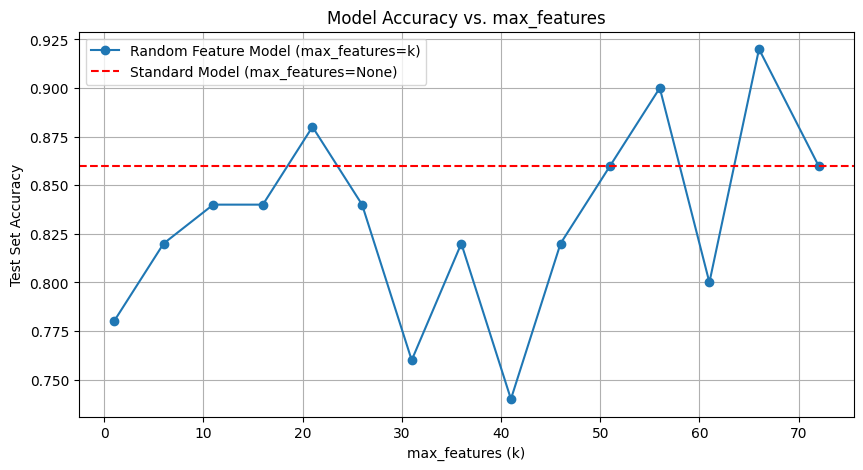

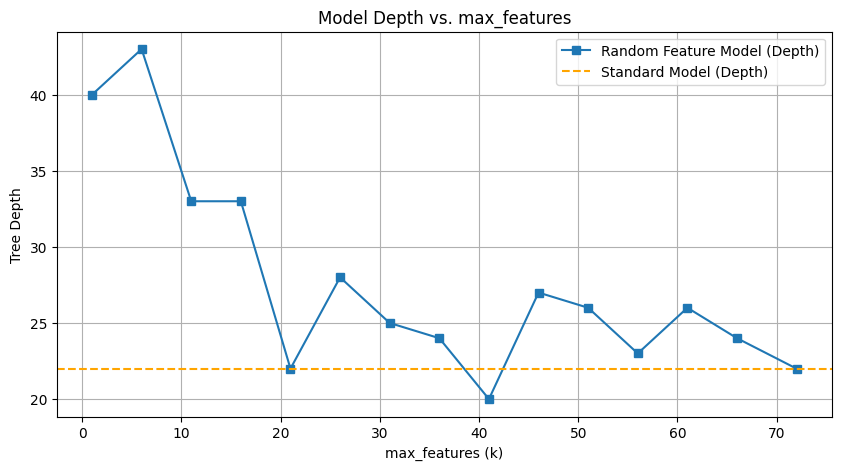

In [13]:
# --- Plot Accuracy Trend ---
plt.figure(figsize=(10, 5))
plt.plot(feature_range, acc_B_list, marker='o', label='Random Feature Model (max_features=k)')
# Note: Model A's accuracy is the same for all k, so we just plot the last value
plt.axhline(y=acc_A_list[-1], color='r', linestyle='--', label='Standard Model (max_features=None)')
plt.title("Model Accuracy vs. max_features")
plt.xlabel("max_features (k)")
plt.ylabel("Test Set Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Plot Depth Trend ---
plt.figure(figsize=(10, 5))
plt.plot(feature_range, depth_B_list, marker='s', label='Random Feature Model (Depth)')
plt.axhline(y=depth_A_list[-1], color='orange', linestyle='--', label='Standard Model (Depth)')
plt.title("Model Depth vs. max_features")
plt.xlabel("max_features (k)")
plt.ylabel("Tree Depth")
plt.legend()
plt.grid(True)
plt.show()